<a href="https://colab.research.google.com/github/seaknows/seaknows.github.io/blob/main/jane_street_real_time_market_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r drive/MyDrive/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.9 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement sklearn_pandas==2.3.0 (from versions: 0.0.1, 0.0.2, 0.0.3, 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 0.0.10, 0.0.12, 1.0.0, 1.1.0, 1.2.0, 1.3.0, 1.4.0, 1.5.0, 1.6.0, 1.7.0, 1.8.0, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.2.0)
ERROR: No matching distribution found for sklearn_pandas==2.3.0


In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import pandas as pd
import polars as pl
import numpy as np
import pyarrow.parquet as pq
import time
import gc

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# stats
import random
import scipy.stats
# from fitter import Fitter, get_common_distributions, get_distributions

# other stuff
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_data(file_paths):
    return pd.concat([pd.read_parquet(file) for file in file_paths])

# Define train and test file paths
train_files = [f'/content/drive/MyDrive/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet' for i in range(10)]

In [4]:
# Load subsets of train data and test data
train_df = load_data(train_files[0:4])

In [5]:
train_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


In [6]:
train_df.shape

(11802114, 92)

# **GLM**

In [9]:
df = train_df[train_df.columns[train_df.isna().sum()==0]]

In [12]:
cols = ['feature_05', 'feature_06','feature_07', 'feature_09', 'feature_10',
        'feature_11', 'feature_12','feature_13', 'feature_14', 'feature_20',
        'feature_22', 'feature_23','feature_24', 'feature_25', 'feature_28',
        'feature_29', 'feature_30','feature_34', 'feature_35', 'feature_36',
        'feature_38', 'feature_48','feature_49', 'feature_59', 'feature_60',
        'feature_61', 'feature_67','feature_68', 'feature_69', 'feature_70',
        'feature_71', 'feature_72','feature_77', 'feature_78']

In [33]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

def weighted_r2_score(y_true, y_pred, weights):
    numerator = np.sum(weights * (y_true - y_pred)**2)
    denominator = np.sum(weights * y_true**2)
    return 1 - numerator/denominator

def fit_glm(train_df, val_df=None, test_df=None, target_col='responder_6', n_features=None):
    # Separate features and target
    feature_cols = [col for col in cols if col not in [target_col, 'weight']]
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    w_train = train_df['weight']

    # Feature selection if specified
    if n_features is not None:
        selector = SelectKBest(score_func=f_regression, k=n_features)
        X_train_selected = selector.fit_transform(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()].tolist()
        X_train = X_train[selected_features]
        if val_df is not None:
            X_val = val_df[selected_features]
        if test_df is not None:
            X_test = test_df[selected_features]
    else:
        if val_df is not None:
            X_val = val_df[feature_cols]
        if test_df is not None:
            X_test = test_df[feature_cols]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = sm.add_constant(X_train_scaled)

    # Fit GLM
    model = sm.GLM(y_train, X_train_scaled, family=sm.families.Gaussian())
    results = model.fit()

    # Calculate train score
    train_pred = results.predict(X_train_scaled)
    train_r2 = weighted_r2_score(y_train, train_pred, w_train)
    print(f"Train R2: {train_r2:.4f}")

    # Validate if validation set provided
    if val_df is not None:
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = sm.add_constant(X_val_scaled)
        val_pred = results.predict(X_val_scaled)
        val_r2 = weighted_r2_score(val_df[target_col], val_pred, val_df['weight'])
        print(f"Validation R2: {val_r2:.4f}")

    # Test if test set provided
    if test_df is not None:
        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = sm.add_constant(X_test_scaled)
        test_pred = results.predict(X_test_scaled)
        test_r2 = weighted_r2_score(test_df[target_col], test_pred, test_df['weight'])
        print(f"Test R2: {test_r2:.4f}")

    model_data = {
        'model': results,
        'scaler': scaler,
        'selected_features': selected_features if n_features else feature_cols
    }

    return model_data

In [35]:
def predict_glm(model, scaler, new_data):
    X_new = scaler.transform(new_data)
    X_new = sm.add_constant(X_new)
    return model.predict(X_new)

In [34]:
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

n_total = len(df)
n_train = int(n_total * train_ratio)
n_valid = int(n_total * valid_ratio)
n_test = n_total - n_train - n_valid

train_df = df.iloc[:n_train].reset_index(drop=True)
valid_df = df.iloc[n_train:n_train + n_valid].reset_index(drop=True)
test_df = df.iloc[n_train + n_valid:].reset_index(drop=True)

In [19]:
model_data = fit_glm(train_df, valid_df, test_df, n_features=50)  # Select top 10 features

Train R2: 0.0064
Validation R2: 0.0048
Test R2: 0.0027


In [36]:
trained_model = model_data['model']
scaler = model_data['scaler']
selected_features = model_data['selected_features']

In [50]:
predictions = predict_glm(trained_model, scaler, train_df[cols])

In [55]:
train_df['responder_6'].iloc[:n_obs].values

array([ 0.77598065,  0.7036654 ,  2.109352  ,  1.1141373 , -3.5728202 ,
        0.84055007, -0.80789155,  0.96538734,  0.751976  ,  0.63527656],
      dtype=float32)

In [56]:
train_df['responder_6']

,responder_6
0,0.775981
1,0.703665
2,2.109352
3,1.114137
4,-3.572820
...,...
9441686,0.433674
9441687,-0.108321
9441688,1.363480
9441689,-0.504541


In [58]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_predictions(y_true, y_pred, n_obs=100, title='Model Predictions'):
   # Create figure with secondary y-axis
   fig = make_subplots(rows=1, cols=1)

   # Add traces
   fig.add_trace(
       go.Scatter(
           x=list(range(n_obs)),
           y=y_true[:n_obs],
           name="Observed",
           mode='lines+markers',
           line=dict(color='blue'),
           opacity=0.6
       )
   )

   fig.add_trace(
       go.Scatter(
           x=list(range(n_obs)),
           y=y_pred[:n_obs],
           name="Predicted",
           mode='lines+markers',
           line=dict(color='red'),
           opacity=0.6
       )
   )

   # Update layout
   fig.update_layout(
       title=title,
       xaxis_title="Observation Index",
       yaxis_title="Responder_6 Value",
       hovermode='x unified',
       template='plotly_white',
       showlegend=True,
       height=600,
       width=1000
   )

   fig.show()

# Usage:
plot_predictions(
   train_df['responder_6'].values,
   predictions,
   n_obs=100,
   title='Predicted vs Observed for First 100 Observations'
)

## **MLP**

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.express as px
import plotly.graph_objects as go

In [8]:
def weighted_r2_score(y_true, y_pred, weights):
    """
    Computes the Weighted R² score.

    Parameters:
    - y_true (np.array): Actual target values.
    - y_pred (np.array): Predicted target values.
    - weights (np.array): Sample weights.

    Returns:
    - float: Weighted R² score.
    """
    numerator = np.sum(weights * (y_true - y_pred) ** 2)
    denominator = np.sum(weights * (y_true - np.average(y_true, weights=weights)) ** 2)
    return 1 - numerator / denominator

In [13]:
# Define split ratios
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Calculate the number of observations for each set
df = train_df[train_df.columns[train_df.isna().sum()==0]]

n_total = len(df)
n_train = int(n_total * train_ratio)
n_valid = int(n_total * valid_ratio)
n_test = n_total - n_train - n_valid  # Ensures all data is used

# Perform the split
train_df = df.iloc[:n_train].reset_index(drop=True)
valid_df = df.iloc[n_train:n_train + n_valid].reset_index(drop=True)
test_df = df.iloc[n_train + n_valid:].reset_index(drop=True)

# Verify the splits
print(f"Total samples: {n_total}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

Total samples: 8261479
Training samples: 5783035
Validation samples: 1239221
Test samples: 1239223


In [14]:
# Define the target and weight columns
target_col = 'responder_6'
weight_col = 'weight'

# Extract feature columns (exclude target and weight)
feature_cols = [col for col in cols]

# Feature Selection: Select Top N Features based on F-test
n_features = 10  # You can adjust this number based on your dataset

selector = SelectKBest(score_func=f_regression, k=n_features)
selector.fit(train_df[feature_cols], train_df[target_col])

selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f"Selected Features ({n_features}): {selected_features}")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[selected_features])
X_valid_scaled = scaler.transform(valid_df[selected_features])
X_test_scaled = scaler.transform(test_df[selected_features])

# Extract target and weights
y_train = train_df[target_col].values
w_train = train_df[weight_col].values

y_valid = valid_df[target_col].values
w_valid = valid_df[weight_col].values

y_test = test_df[target_col].values
w_test = test_df[weight_col].values

Selected Features (10): ['feature_05', 'feature_06', 'feature_07', 'feature_10', 'feature_13', 'feature_38', 'feature_59', 'feature_60', 'feature_68', 'feature_69']


In [15]:
# # Define the input shape based on selected features
input_shape = X_train_scaled.shape[1]

# # Define the MLP architecture
# def build_mlp(input_dim):
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_dim=input_dim),
#         layers.Dense(32, activation='relu'),
#         layers.Dense(16, activation='relu'),
#         layers.Dense(1)  # Output layer for regression
#     ])
#     return model

# # Build the model
# model = build_mlp(input_shape)

# # Compile the model
# model.compile(optimizer='adam',
#               loss='mse',  # Mean Squared Error for regression
#               metrics=['mae'])  # Mean Absolute Error as an additional metric

# # Display the model summary
# model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K

def r2_metric(y_true, y_pred):
    """
    Computes the R² metric.

    Parameters:
    - y_true: Ground truth values.
    - y_pred: Predicted values.

    Returns:
    - R² score.
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [18]:
# Build the MLP model
def build_mlp(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    return model

model = build_mlp(input_shape)

# Compile the model with R² as a metric
model.compile(optimizer='adam',
              loss='mse',  # Mean Squared Error for regression
              metrics=['mae', r2_metric])

In [19]:
# Define Early Stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=32000,
    validation_data=(X_valid_scaled, y_valid, w_valid),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - loss: 1.4426 - mae: 0.6009 - r2_metric: -32441.2832 - val_loss: 1.3368 - val_mae: 0.6006 - val_r2_metric: -32242.6953
Epoch 2/100
 76/181 ━━━━━━━━━━━━━━━━━━━━ 1:13 702ms/step - loss: 1.4256 - mae: 0.5973 - r2_metric: -32484.6855

KeyboardInterrupt: 

## **Auto-Encoder**

In [20]:
def create_autoencoder(input_dim, output_dim, noise=0.05):
    i = Input(shape=(input_dim,))
    encoded = BatchNormalization()(i)
    encoded = GaussianNoise(noise)(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    decoded = Dropout(0.2)(encoded)
    decoded = Dense(input_dim, name='decoded')(decoded)
    x = Dense(32, activation='relu')(decoded)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(output_dim, activation='sigmoid', name='label_output')(x)

    encoder = Model(inputs=i, outputs=decoded, name='encoder')
    autoencoder = Model(inputs=i, outputs=[decoded, x], name='autoencoder')

    autoencoder.compile(optimizer=Adam(0.001),
                        loss={'decoded': 'mse', 'label_output': 'binary_crossentropy'},
                        loss_weights={'decoded': 1.0, 'label_output': 1.0})
    return autoencoder, encoder


In [21]:
def create_model(hp, input_dim, output_dim, encoder):
    inputs = Input(shape=(input_dim,))

    x = encoder(inputs)
    x = Concatenate()([x, inputs])  # Use both raw and encoded features
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('init_dropout', 0.0, 0.5))(x)

    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int(f'num_units_{i}', 64, 256))(x)
        x = BatchNormalization()(x)
        x = Activation('swish')(x)  # Using Keras activation
        x = Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.5))(x)

    x = Dense(output_dim, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', 1e-5, 1e-1, sampling='LOG', default=1e-3)),
                  loss=BinaryCrossentropy(label_smoothing=hp.Float('label_smoothing', 0.0, 0.1)),
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model


In [23]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization, GaussianNoise, Dropout, Concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import keras_tuner as kt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [25]:
def weighted_r2_score(y_true, y_pred, weights):
    """
    Computes the Weighted R² score.

    Parameters:
    - y_true (np.array): Actual target values.
    - y_pred (np.array): Predicted target values.
    - weights (np.array): Sample weights.

    Returns:
    - float: Weighted R² score.
    """
    numerator = np.sum(weights * (y_true - y_pred)**2)
    denominator = np.sum(weights * (y_true - np.average(y_true, weights=weights))**2)
    return 1 - numerator / denominator


In [26]:
def r2_metric_tf(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())
    return r2

In [27]:
# Example DataFrame loading
# df = pd.read_csv('your_financial_data.csv')

# Define target and weight columns
target_col = 'responder_6'  # Replace with your actual target column
weight_col = 'weight'        # Replace with your actual weight column

# Split the data into features and target
feature_cols = [col for col in cols if col not in [target_col, weight_col]]

X = df[feature_cols].values
y = df[target_col].values
w = df[weight_col].values

# Split into Training, Validation, and Test sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp, w_train, w_temp = train_test_split(
    X, y, w, test_size=0.3, shuffle=False  # Shuffle=False to maintain chronological order
)

X_valid, X_test, y_valid, y_test, w_valid, w_test = train_test_split(
    X_temp, y_temp, w_temp, test_size=0.5, shuffle=False
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_valid)}")
print(f"Test samples: {len(X_test)}")

Training samples: 5783035
Validation samples: 1239222
Test samples: 1239222


In [30]:
# Feature Selection: Select Top N Features based on F-test
n_features = 10  # Adjust based on your dataset

selector = SelectKBest(score_func=f_regression, k=n_features)
selector.fit(X_train, y_train)

selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f"Selected Features ({n_features}): {selected_features}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[:, selector.get_support()])
X_valid_scaled = scaler.transform(X_valid[:, selector.get_support()])
X_test_scaled = scaler.transform(X_test[:, selector.get_support()])

Selected Features (10): ['feature_05', 'feature_06', 'feature_07', 'feature_10', 'feature_13', 'feature_38', 'feature_59', 'feature_60', 'feature_68', 'feature_69']


In [32]:
from tensorflow.keras.layers import Input, BatchNormalization, GaussianNoise, Dense, Dropout
from tensorflow.keras.models import Model

def create_autoencoder(input_dim, output_dim, noise=0.05):
    i = Input(shape=(input_dim,))
    encoded = BatchNormalization()(i)
    encoded = GaussianNoise(noise)(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    decoded = Dropout(0.2)(encoded)
    decoded = Dense(input_dim, name='decoded')(decoded)
    x = Dense(32, activation='relu')(decoded)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(output_dim, activation='sigmoid', name='label_output')(x)

    encoder = Model(inputs=i, outputs=decoded, name='encoder')
    autoencoder = Model(inputs=i, outputs=[decoded, x], name='autoencoder')

    autoencoder.compile(optimizer=Adam(0.001),
                        loss={'decoded': 'mse', 'label_output': 'binary_crossentropy'},
                        loss_weights={'decoded': 1.0, 'label_output': 1.0})
    return autoencoder, encoder

In [34]:
x = Dense(1, activation='linear', name='label_output')(x)

NameError: name 'x' is not defined

In [11]:
# train_df[train_df.columns[train_df.isna().sum()/len(train_df)<0.5]]

In [33]:
train_df.columns[train_df.isna().sum()==0]

Index(['date_id', 'time_id', 'symbol_id', 'weight', 'feature_05', 'feature_06',
       'feature_07', 'feature_09', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_20', 'feature_22', 'feature_23',
       'feature_24', 'feature_25', 'feature_28', 'feature_29', 'feature_30',
       'feature_34', 'feature_35', 'feature_36', 'feature_38', 'feature_48',
       'feature_49', 'feature_59', 'feature_60', 'feature_61', 'feature_67',
       'feature_68', 'feature_69', 'feature_70', 'feature_71', 'feature_72',
       'feature_77', 'feature_78', 'responder_0', 'responder_1', 'responder_2',
       'responder_3', 'responder_4', 'responder_5', 'responder_6',
       'responder_7', 'responder_8'],
      dtype='object')

In [13]:
cols = ['feature_05', 'feature_06',
       'feature_07', 'feature_09', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_20', 'feature_22', 'feature_23',
       'feature_24', 'feature_25', 'feature_28', 'feature_29', 'feature_30',
       'feature_34', 'feature_35', 'feature_36', 'feature_38', 'feature_48',
       'feature_49', 'feature_59', 'feature_60', 'feature_61', 'feature_67',
       'feature_68', 'feature_69', 'feature_70', 'feature_71', 'feature_72',
       'feature_77', 'feature_78']

In [34]:
X = train_df[cols]
y = train_df['responder_6']
sample_weight = train_df['weight']

In [15]:
def weighted_zero_mean_r2(y_true, y_pred, weights):
    y_true = y_true - np.average(y_true, weights=weights)
    numerator = np.sum(weights * (y_true - y_pred) ** 2)
    denominator = np.sum(weights * y_true ** 2)
    return 1 - numerator / denominator

In [16]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',  # Use 'gpu_hist' if using GPU
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
    }

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for train_index, valid_index in tscv.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        w_train, w_valid = sample_weight.iloc[train_index], sample_weight.iloc[valid_index]

        dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, weight=w_valid)

        model = xgb.train(
            params,
            dtrain,
            evals=[(dvalid, 'validation')],
            num_boost_round=params['n_estimators'],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        y_pred = model.predict(dvalid)
        score = weighted_zero_mean_r2(y_valid.values, y_pred, w_valid.values)
        scores.append(score)

    return np.mean(scores)

In [17]:
# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-22 18:48:58,103] A new study created in memory with name: no-name-dd89639b-d41e-4cbf-84e9-58ddb72ec5e9
[I 2024-11-22 18:51:26,463] Trial 0 finished with value: -0.0027473092079162596 and parameters: {'lambda': 0.40065222024602143, 'alpha': 0.03649028977783648, 'colsample_bytree': 0.9870580977605716, 'subsample': 0.7518822890670477, 'learning_rate': 0.19525304159230927, 'n_estimators': 651, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.894716610792087}. Best is trial 0 with value: -0.0027473092079162596.
[I 2024-11-22 18:54:45,342] Trial 1 finished with value: 0.0058095335960388185 and parameters: {'lambda': 3.3048760418868257, 'alpha': 0.0017733685973243376, 'colsample_bytree': 0.898665314282775, 'subsample': 0.8506575390568387, 'learning_rate': 0.10911286123762684, 'n_estimators': 420, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.019169159589847166}. Best is trial 1 with value: 0.0058095335960388185.
[I 2024-11-22 18:59:20,513] Trial 2 finished with value: 0.00768

KeyboardInterrupt: 

In [18]:
study_params = study.best_params

In [19]:
study_params

{'lambda': 0.015641406933454526,
 'alpha': 0.016176270706667842,
 'colsample_bytree': 0.57180649508114,
 'subsample': 0.5338813479041535,
 'learning_rate': 0.010075514507310632,
 'n_estimators': 852,
 'max_depth': 9,
 'min_child_weight': 9,
 'gamma': 0.11402209287210727}

In [ ]:
# {'lambda': 0.010186655107275861, 'alpha': 0.012588871972433715, 'colsample_bytree': 0.704960794123039, 'subsample': 0.5493211321514359, 'learning_rate': 0.010622502312529692, 'n_estimators': 927, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.2986557101666143}

In [ ]:
# [I 2024-11-22 20:28:32,180] Trial 11 finished with value: 0.009794354438781738 and parameters: {'lambda': 0.0092965741627004, 'alpha': 0.013490490851412212, 'colsample_bytree': 0.7021097601942339, 'subsample': 0.5044641719273375, 'learning_rate': 0.01027764821982781, 'n_estimators': 951, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 0.1655749359018374}. Best is trial 11 with value: 0.009794354438781738.
# [I 2024-11-22 19:08:13,698] Trial 3 finished with value: 0.008621037006378174 and parameters: {'lambda': 0.4609116302245465, 'alpha': 1.11548861767567, 'colsample_bytree': 0.9577612145532031, 'subsample': 0.8487938416729449, 'learning_rate': 0.01737647912127486, 'n_estimators': 268, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 2.5652188170658397}. Best is trial 3 with value: 0.008621037006378174.
# [I 2024-11-22 19:25:41,474] Trial 4 finished with value: 0.009669888019561767 and parameters: {'lambda': 0.06946953292657011, 'alpha': 0.3701567281759277, 'colsample_bytree': 0.8798998859562759, 'subsample': 0.5654939547947895, 'learning_rate': 0.011030050716276506, 'n_estimators': 825, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 7.900347117806401}. Best is trial 4 with value: 0.009669888019561767.
# [I 2024-11-22 20:10:31,701] Trial 10 finished with value: 0.009750854969024659 and parameters: {'lambda': 0.010186655107275861, 'alpha': 0.012588871972433715, 'colsample_bytree': 0.704960794123039, 'subsample': 0.5493211321514359, 'learning_rate': 0.010622502312529692, 'n_estimators': 927, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.2986557101666143}. Best is trial 10 with value: 0.009750854969024659.
# [I 2024-11-22 19:08:13,698] Trial 3 finished with value: 0.008621037006378174 and parameters: {'lambda': 0.4609116302245465, 'alpha': 1.11548861767567, 'colsample_bytree': 0.9577612145532031, 'subsample': 0.8487938416729449, 'learning_rate': 0.01737647912127486, 'n_estimators': 268, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 2.5652188170658397}. Best is trial 3 with value: 0.008621037006378174.

In [ ]:
# [I 2024-11-22 18:48:58,103] A new study created in memory with name: no-name-dd89639b-d41e-4cbf-84e9-58ddb72ec5e9
# [I 2024-11-22 18:51:26,463] Trial 0 finished with value: -0.0027473092079162596 and parameters: {'lambda': 0.40065222024602143, 'alpha': 0.03649028977783648, 'colsample_bytree': 0.9870580977605716, 'subsample': 0.7518822890670477, 'learning_rate': 0.19525304159230927, 'n_estimators': 651, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 2.894716610792087}. Best is trial 0 with value: -0.0027473092079162596.
# [I 2024-11-22 18:54:45,342] Trial 1 finished with value: 0.0058095335960388185 and parameters: {'lambda': 3.3048760418868257, 'alpha': 0.0017733685973243376, 'colsample_bytree': 0.898665314282775, 'subsample': 0.8506575390568387, 'learning_rate': 0.10911286123762684, 'n_estimators': 420, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.019169159589847166}. Best is trial 1 with value: 0.0058095335960388185.
# [I 2024-11-22 18:59:20,513] Trial 2 finished with value: 0.0076865673065185545 and parameters: {'lambda': 0.0940081272082052, 'alpha': 0.08632728860792255, 'colsample_bytree': 0.9375011019955646, 'subsample': 0.6442989855882753, 'learning_rate': 0.14164586051715133, 'n_estimators': 211, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 4.96100955856697}. Best is trial 2 with value: 0.0076865673065185545.
# [I 2024-11-22 20:48:04,789] Trial 12 finished with value: 0.009894263744354249 and parameters: {'lambda': 0.006377371574737322, 'alpha': 0.005328589470467155, 'colsample_bytree': 0.6730212865461578, 'subsample': 0.5126117869968491, 'learning_rate': 0.010140897408298528, 'n_estimators': 963, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0.4119672879006309}. Best is trial 12 with value: 0.009894263744354249.


In [22]:
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['tree_method'] = 'hist'  # Use 'gpu_hist' if using GPU

In [23]:
best_params

{'lambda': 0.015641406933454526,
 'alpha': 0.016176270706667842,
 'colsample_bytree': 0.57180649508114,
 'subsample': 0.5338813479041535,
 'learning_rate': 0.010075514507310632,
 'n_estimators': 852,
 'max_depth': 9,
 'min_child_weight': 9,
 'gamma': 0.11402209287210727,
 'objective': 'reg:squarederror',
 'tree_method': 'hist'}

In [ ]:
# X = train_df[cols]
# y = train_df['responder_6']
# sample_weight = train_df['weight']

In [20]:
# best_params = study.best_params
# best_params['objective'] = 'reg:squarederror'
# best_params['tree_method'] = 'hist'  # Use 'gpu_hist' if using GPU

# dtrain_full = xgb.DMatrix(X, label=y, weight=sample_weight)

In [37]:
df =

,feature_05,feature_06,feature_07,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_20,...,feature_60,feature_61,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_77,feature_78
0,0.851033,0.242971,0.263400,11,7,76,-0.883028,0.003067,-0.744703,0.910130,...,-0.345213,-1.362240,-1.251104,-0.110252,-0.491157,-1.022690,0.152241,-0.659864,-0.335556,-0.281498
1,0.676961,0.151984,0.192465,11,7,76,-0.865307,-0.225629,-0.582163,1.412757,...,0.467994,-1.362240,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,-0.245565,-0.302441
2,1.056285,0.187227,0.249901,11,7,76,-0.675719,-0.199404,-0.586798,0.639589,...,-0.063458,-1.362240,-0.882604,-0.072482,-0.617934,-0.863230,-0.241892,-0.709919,-0.106842,-0.096792
3,1.139366,0.273328,0.306549,42,5,150,-0.694008,3.004091,0.114809,0.241165,...,1.834661,-1.362240,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,-0.215522,-0.296244
4,0.955200,0.262404,0.344457,44,3,16,-0.947351,-0.030018,-0.502379,-0.182024,...,0.411827,-1.362240,-0.948601,-0.136814,-0.447704,-1.141761,0.099631,-0.661928,2.618250,3.418133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7553347,0.668533,0.373242,-0.086007,26,12,158,-0.486779,-0.569306,-0.817757,-1.559832,...,0.083901,0.202007,-0.361614,-0.387753,-0.816377,-0.135953,-0.434895,-0.609561,-0.171869,-0.243503
7553348,0.354851,0.209842,-0.059179,50,1,522,-0.227168,-0.086765,0.029998,0.253919,...,0.404134,0.202007,-0.103793,0.122080,0.230839,-0.327125,-0.352971,-0.238167,-0.376002,-0.211924
7553349,0.359466,0.253410,-0.101865,11,7,76,-0.331391,-0.033178,-0.148229,1.045398,...,0.011019,0.202007,-0.328512,-0.275910,-0.175101,-0.375896,0.315093,-0.087519,-0.259893,-0.223455
7553350,0.319585,0.162702,-0.076796,81,2,59,-0.367176,-0.553747,-0.349592,-0.578691,...,0.335415,0.202007,-0.326678,-0.490708,-0.456306,-0.405597,-0.326233,-0.417354,-0.098033,-0.119870


In [39]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_df = df.iloc[:split_index].reset_index(drop=True)
valid_df = df.iloc[split_index:].reset_index(drop=True)

X_train = train_df[cols]
y_train = train_df['responder_6']
w_train = train_df['weight']

X_valid = valid_df[cols]
y_valid = valid_df['responder_6']
w_valid = valid_df['weight']

In [40]:
train_df.shape, valid_df.shape

((9441691, 92), (2360423, 92))

In [41]:
def weighted_zero_mean_r2_score(y_true, y_pred, weights):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    weights = np.array(weights)

    y_true_zero_mean = y_true - np.average(y_true, weights=weights)

    numerator = np.sum(weights * (y_true_zero_mean - y_pred) ** 2)
    denominator = np.sum(weights * y_true_zero_mean ** 2)

    if denominator == 0:
        return 0
    else:
        return 1 - numerator / denominator

def weighted_zero_mean_r2_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    weights = dtrain.get_weight()

    r2 = weighted_zero_mean_r2_score(y_true, y_pred, weights)

    # Return negative R² because XGBoost minimizes the evaluation metric
    return 'weighted_zero_mean_r2', -r2

In [42]:
dtrain_full = xgb.DMatrix(X_train, label=y_train, weight=w_train)
dvalid_full = xgb.DMatrix(X_valid, label=y_valid, weight=w_valid)

In [43]:
final_model = xgb.train(
    best_params,
    dtrain_full,
    evals=[(dvalid_full, 'validation')],
    num_boost_round=best_params['n_estimators'],
    feval=weighted_zero_mean_r2_eval,
    early_stopping_rounds=50,
    verbose_eval=10  # Set to a positive integer to see progress
)

[0]	validation-rmse:0.92673	validation-weighted_zero_mean_r2:-0.00007
[10]	validation-rmse:0.92621	validation-weighted_zero_mean_r2:-0.00118
[20]	validation-rmse:0.92584	validation-weighted_zero_mean_r2:-0.00199
[30]	validation-rmse:0.92552	validation-weighted_zero_mean_r2:-0.00268
[40]	validation-rmse:0.92515	validation-weighted_zero_mean_r2:-0.00347
[50]	validation-rmse:0.92484	validation-weighted_zero_mean_r2:-0.00415
[60]	validation-rmse:0.92458	validation-weighted_zero_mean_r2:-0.00471
[70]	validation-rmse:0.92431	validation-weighted_zero_mean_r2:-0.00529
[80]	validation-rmse:0.92411	validation-weighted_zero_mean_r2:-0.00571
[90]	validation-rmse:0.92390	validation-weighted_zero_mean_r2:-0.00618
[100]	validation-rmse:0.92373	validation-weighted_zero_mean_r2:-0.00654
[110]	validation-rmse:0.92356	validation-weighted_zero_mean_r2:-0.00690
[120]	validation-rmse:0.92341	validation-weighted_zero_mean_r2:-0.00723
[130]	validation-rmse:0.92327	validation-weighted_zero_mean_r2:-0.00752
[14

In [44]:
# 10. Predict on the validation set
y_pred_valid = final_model.predict(dvalid_full)

# 11. Calculate the weighted zero-mean R² score
r2_valid = weighted_zero_mean_r2_score(y_valid, y_pred_valid, w_valid)
print(f"Weighted Zero-Mean R² on Validation Set: {r2_valid:.6f}")

Weighted Zero-Mean R² on Validation Set: 0.010221


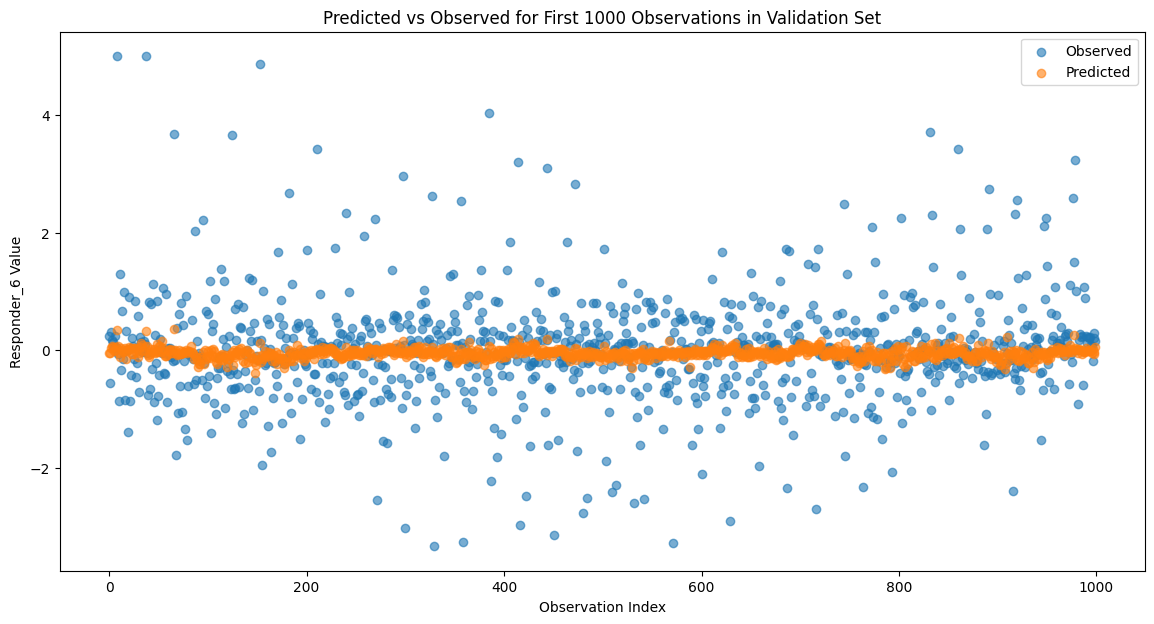

In [57]:
n_obs = 1000
n_obs = min(n_obs, len(y_valid))

y_true_plot = y_valid.iloc[:n_obs].values
y_pred_plot = y_pred_valid[:n_obs]

plt.figure(figsize=(14, 7))
plt.scatter(range(n_obs), y_true_plot, label='Observed', alpha=0.6)
plt.scatter(range(n_obs), y_pred_plot, label='Predicted', alpha=0.6)
plt.title('Predicted vs Observed for First 1000 Observations in Validation Set')
plt.xlabel('Observation Index')
plt.ylabel('Responder_6 Value')
plt.legend()
plt.show()

# (Optional) Line Plot for better trend visualization
# plt.figure(figsize=(14, 7))
# plt.plot(range(n_obs), y_true_plot, label='Observed', alpha=0.6)
# plt.plot(range(n_obs), y_pred_plot, label='Predicted', alpha=0.6)
# plt.title('Predicted vs Observed for First 1000 Observations in Validation Set')
# plt.xlabel('Observation Index')
# plt.ylabel('Responder_6 Value')
# plt.legend()
# plt.show()

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid, weight=w_valid)

In [ ]:
final_model = xgb.train(
    best_params,
    dtrain,
    # feval=weighted_zero_mean_r2_eval,
    num_boost_round=best_params['n_estimators']
)

In [ ]:
dvalid = xgb.DMatrix(X_valid, label=y_valid, weight=w_valid)


In [ ]:
# model = xgb.train(
#     best_params,
#     dtrain,
#     evals=[(dvalid, 'validation')],
#     feval=weighted_zero_mean_r2_eval,
#     num_boost_round=best_params['n_estimators'],
#     early_stopping_rounds=50,
#     verbose_eval=False
# )

In [8]:
df = train_df[train_df.columns[train_df.isna().sum()==0]]

In [9]:
df.head()

,date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_09,feature_10,feature_11,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,0.851033,0.242971,0.263400,11,7,76,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,0.676961,0.151984,0.192465,11,7,76,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,1.056285,0.187227,0.249901,11,7,76,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,1.139366,0.273328,0.306549,42,5,150,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,0.955200,0.262404,0.344457,44,3,16,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


In [11]:
cols = ['feature_05', 'feature_06',
       'feature_07', 'feature_09', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_20', 'feature_22', 'feature_23',
       'feature_24', 'feature_25', 'feature_28', 'feature_29', 'feature_30',
       'feature_34', 'feature_35', 'feature_36', 'feature_38', 'feature_48',
       'feature_49', 'feature_59', 'feature_60', 'feature_61', 'feature_67',
       'feature_68', 'feature_69', 'feature_70', 'feature_71', 'feature_72',
       'feature_77', 'feature_78']

In [12]:
# Create splits (70-15-15)
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.15 * total_rows)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (8261479, 47)
Val shape: (1770317, 47)
Test shape: (1770318, 47)


In [32]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

def weighted_r2_score(y_true, y_pred, weights):
    numerator = np.sum(weights * (y_true - y_pred)**2)
    denominator = np.sum(weights * y_true**2)
    return 1 - numerator/denominator

def fit_glm(train_df, val_df=None, test_df=None, target_col='responder_6', n_features=None):
    # Separate features and target
    feature_cols = [col for col in cols if col not in [target_col, 'weight']]
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    w_train = train_df['weight']

    # Feature selection if specified
    if n_features is not None:
        selector = SelectKBest(score_func=f_regression, k=n_features)
        X_train_selected = selector.fit_transform(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()].tolist()
        X_train = X_train[selected_features]
        if val_df is not None:
            X_val = val_df[selected_features]
        if test_df is not None:
            X_test = test_df[selected_features]
    else:
        if val_df is not None:
            X_val = val_df[feature_cols]
        if test_df is not None:
            X_test = test_df[feature_cols]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = sm.add_constant(X_train_scaled)

    # Fit GLM
    model = sm.GLM(y_train, X_train_scaled, family=sm.families.Gaussian())
    results = model.fit()

    # Calculate train score
    train_pred = results.predict(X_train_scaled)
    train_r2 = weighted_r2_score(y_train, train_pred, w_train)
    print(f"Train R2: {train_r2:.4f}")

    # Validate if validation set provided
    if val_df is not None:
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = sm.add_constant(X_val_scaled)
        val_pred = results.predict(X_val_scaled)
        val_r2 = weighted_r2_score(val_df[target_col], val_pred, val_df['weight'])
        print(f"Validation R2: {val_r2:.4f}")

    # Test if test set provided
    if test_df is not None:
        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = sm.add_constant(X_test_scaled)
        test_pred = results.predict(X_test_scaled)
        test_r2 = weighted_r2_score(test_df[target_col], test_pred, test_df['weight'])
        print(f"Test R2: {test_r2:.4f}")

    model_data = {
        'model': results,
        'scaler': scaler,
        'selected_features': selected_features if n_features else feature_cols
    }

    return model_data

In [33]:
model_data = fit_glm(train_df, val_df, test_df, n_features=50)  # Select top 10 features

Train R2: 0.0070
Validation R2: 0.0028
Test R2: 0.0029


In [13]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class TimeSeriesModel:
    def __init__(self, params=None):
        self.params = params or {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'tree_method': 'hist',  # For faster training
            'early_stopping_rounds': 50
        }
        self.scaler = StandardScaler()
        self.model = None
        self.features = None

    def weighted_r2_score(self, y_true, y_pred, weights):
        numerator = np.sum(weights * (y_true - y_pred)**2)
        denominator = np.sum(weights * y_true**2)
        return 1 - numerator/denominator

    def prepare_data(self, df, feature_cols):
        self.features = feature_cols
        X = df[feature_cols]
        y = df['responder_6']
        weights = df['weight']
        return X, y, weights

    def fit(self, train_df, val_df, feature_cols):
        X_train, y_train, w_train = self.prepare_data(train_df, feature_cols)
        X_val, y_val, w_val = self.prepare_data(val_df, feature_cols)

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)

        # Train model
        dtrain = xgb.DMatrix(X_train_scaled, label=y_train, weight=w_train)
        dval = xgb.DMatrix(X_val_scaled, label=y_val, weight=w_val)

        self.model = xgb.train(
            self.params,
            dtrain,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dval, 'val')],
            verbose_eval=100
        )

        return self

    def predict(self, df):
        X = df[self.features]
        X_scaled = self.scaler.transform(X)
        dtest = xgb.DMatrix(X_scaled)
        return self.model.predict(dtest)

    def plot_importance(self, top_n=10):
        importance = self.model.get_score(importance_type='gain')
        df_importance = pd.DataFrame.from_dict(importance, orient='index', columns=['importance'])
        df_importance.sort_values('importance', ascending=False).head(top_n).plot(kind='bar')
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, train_df, val_df, test_df):
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))

        # Time series plot
        train_pred = self.predict(train_df)
        val_pred = self.predict(val_df)
        test_pred = self.predict(test_df)

        axes[0].plot(range(len(train_pred)), train_df['responder_6'], 'b.', label='Train Actual', alpha=0.5)
        axes[0].plot(range(len(train_pred)), train_pred, 'r.', label='Train Predicted', alpha=0.5)

        offset = len(train_pred)
        axes[0].plot(range(offset, offset + len(val_pred)), val_df['responder_6'], 'g.', label='Val Actual', alpha=0.5)
        axes[0].plot(range(offset, offset + len(val_pred)), val_pred, 'y.', label='Val Predicted', alpha=0.5)

        offset += len(val_pred)
        axes[0].plot(range(offset, offset + len(test_pred)), test_df['responder_6'], 'c.', label='Test Actual', alpha=0.5)
        axes[0].plot(range(offset, offset + len(test_pred)), test_pred, 'm.', label='Test Predicted', alpha=0.5)

        axes[0].legend()
        axes[0].set_title('Time Series Prediction')

        # Scatter plot
        all_actual = np.concatenate([train_df['responder_6'], val_df['responder_6'], test_df['responder_6']])
        all_pred = np.concatenate([train_pred, val_pred, test_pred])
        all_weights = np.concatenate([train_df['weight'], val_df['weight'], test_df['weight']])

        scatter = axes[1].scatter(all_actual, all_pred, c=all_weights, alpha=0.5, cmap='viridis')
        axes[1].plot([all_actual.min(), all_actual.max()], [all_actual.min(), all_actual.max()], 'r--')
        plt.colorbar(scatter, ax=axes[1], label='Weight')
        axes[1].set_xlabel('Actual')
        axes[1].set_ylabel('Predicted')
        axes[1].set_title('Predicted vs Actual')

        plt.tight_layout()
        plt.show()

        # Print metrics
        print(f"Train R²: {self.weighted_r2_score(train_df['responder_6'], train_pred, train_df['weight']):.4f}")
        print(f"Val R²: {self.weighted_r2_score(val_df['responder_6'], val_pred, val_df['weight']):.4f}")
        print(f"Test R²: {self.weighted_r2_score(test_df['responder_6'], test_pred, test_df['weight']):.4f}")

    def save_model(self, path):
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'features': self.features
        }
        joblib.dump(model_data, path)

    @classmethod
    def load_model(cls, path):
        model_data = joblib.load(path)
        instance = cls()
        instance.model = model_data['model']
        instance.scaler = model_data['scaler']
        instance.features = model_data['features']
        return instance

[0]	train-rmse:0.87524	val-rmse:0.94586
[100]	train-rmse:0.86167	val-rmse:0.94261
[200]	train-rmse:0.85467	val-rmse:0.94384
[300]	train-rmse:0.84836	val-rmse:0.94487
[400]	train-rmse:0.84315	val-rmse:0.94597
[500]	train-rmse:0.83835	val-rmse:0.94774
[600]	train-rmse:0.83378	val-rmse:0.94878
[700]	train-rmse:0.82969	val-rmse:0.95049
[800]	train-rmse:0.82573	val-rmse:0.95231
[900]	train-rmse:0.82222	val-rmse:0.95418
[999]	train-rmse:0.81889	val-rmse:0.95553


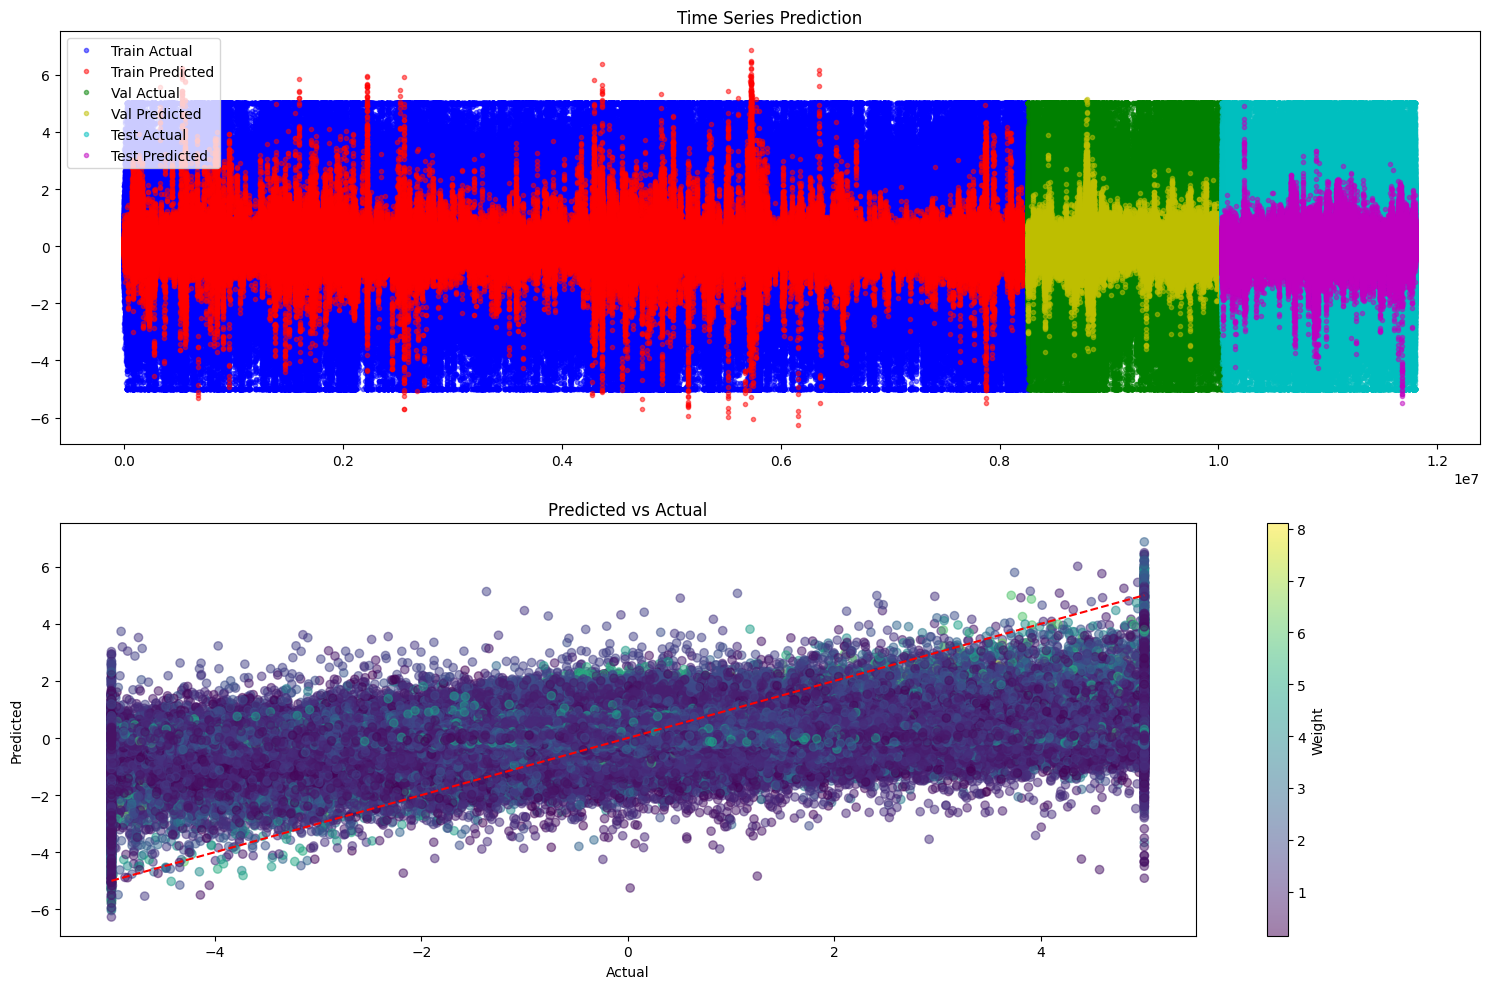

Train R²: 0.1261
Val R²: -0.0197
Test R²: -0.0228


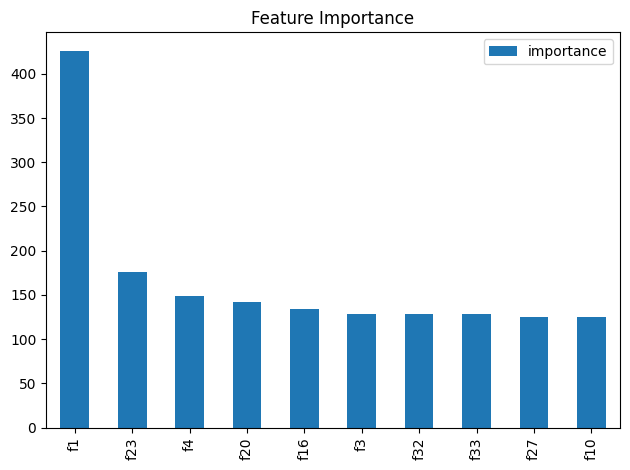

NameError: name 'joblib' is not defined

In [14]:
# Usage example:
feature_cols = [col for col in cols if col not in ['responder_6', 'weight']]

model = TimeSeriesModel()
model.fit(train_df, val_df, feature_cols)

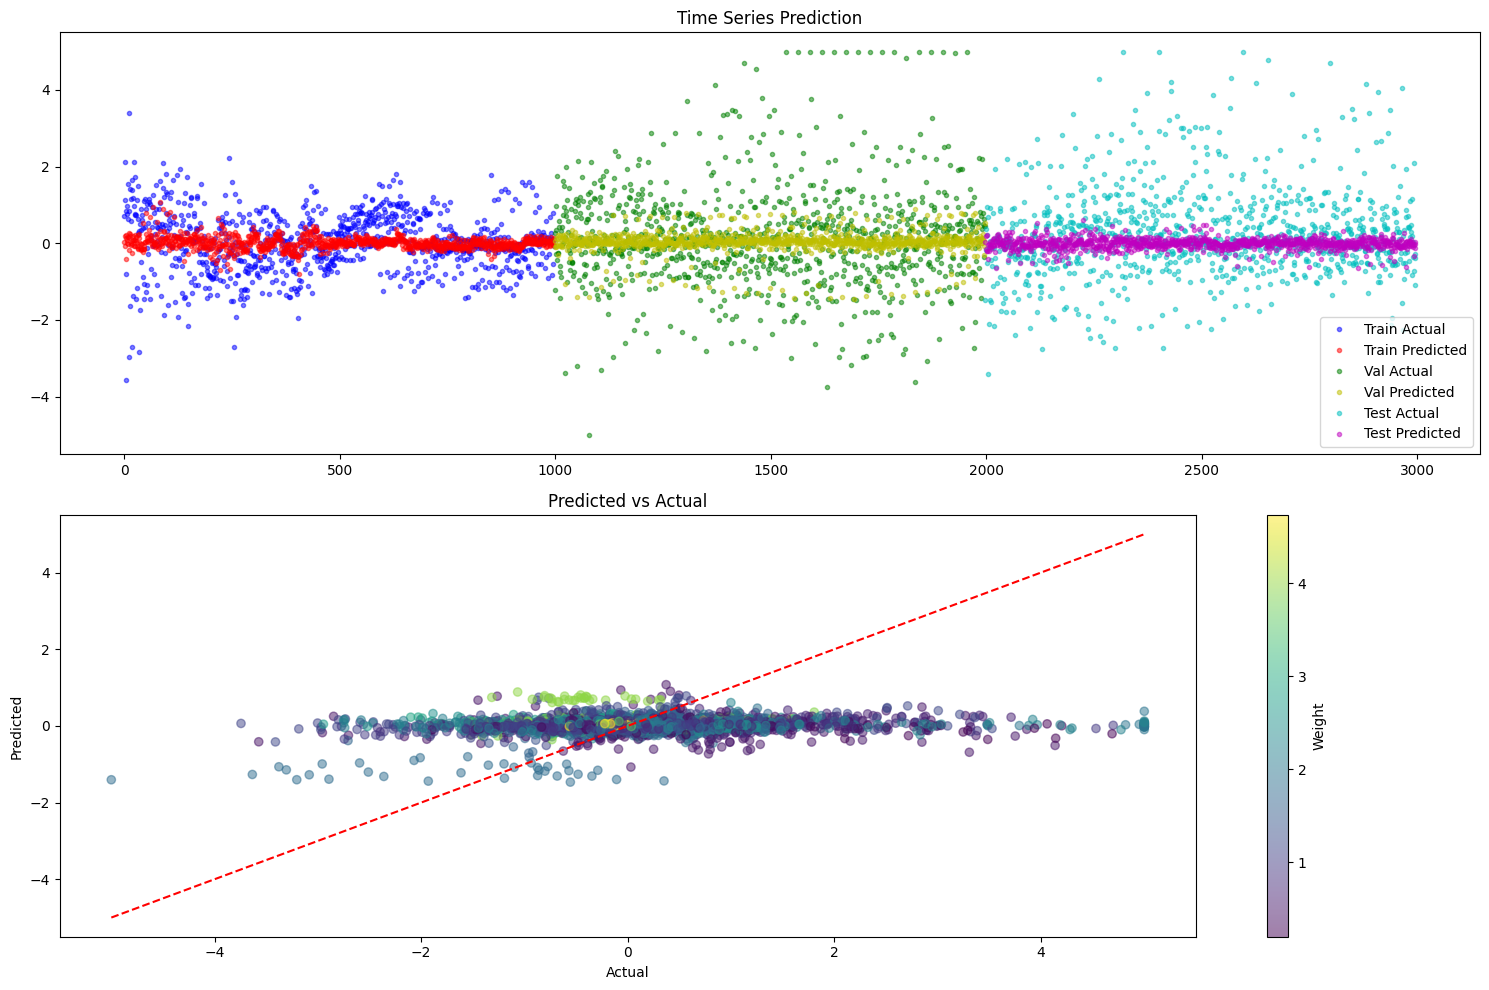

Train R²: 0.0770
Val R²: -0.0087
Test R²: 0.0079


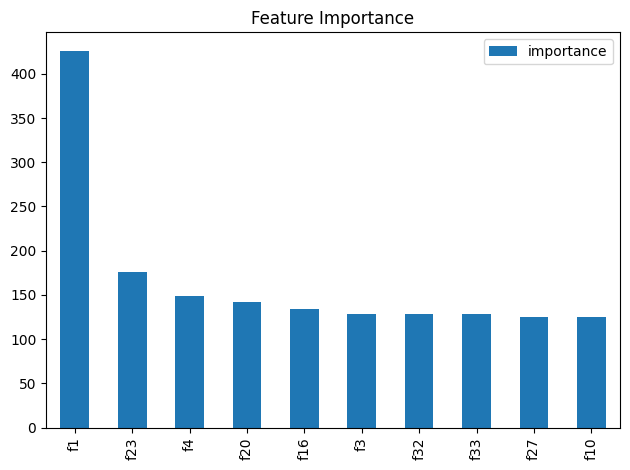

In [16]:
# Plot results
model.plot_predictions(train_df[1:1000], val_df[1:1000], test_df[1:1000])
model.plot_importance()

In [15]:
import joblib


# Save model
model.save_model('/content/drive/MyDrive/xgb_model.joblib')

# Load model
loaded_model = TimeSeriesModel.load_model('/content/drive/MyDrive/xgb_model.joblib')

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class TimeSeriesDataset(Dataset):
    def __init__(self, df, features, target='responder_6', weights='weight', seq_length=10):
        self.scaler = StandardScaler()
        self.features = features

        # Scale features
        X = self.scaler.fit_transform(df[features])
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(df[target].values)
        self.weights = torch.FloatTensor(df[weights].values)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_length],
                self.y[idx+self.seq_length],
                self.weights[idx+self.seq_length])

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :]).squeeze()

class TimeSeriesLSTM:
    def __init__(self, hidden_size=64, num_layers=2, seq_length=10, batch_size=32, epochs=100):
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def weighted_r2_score(self, y_true, y_pred, weights):
        numerator = np.sum(weights * (y_true - y_pred)**2)
        denominator = np.sum(weights * y_true**2)
        return 1 - numerator/denominator

    def fit(self, train_df, val_df, feature_cols):
        self.features = feature_cols

        # Create datasets
        self.train_dataset = TimeSeriesDataset(train_df, feature_cols, seq_length=self.seq_length)
        self.val_dataset = TimeSeriesDataset(val_df, feature_cols, seq_length=self.seq_length)

        # Create dataloaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size)

        # Initialize model
        self.model = LSTMModel(len(feature_cols), self.hidden_size, self.num_layers).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())

        best_val_loss = float('inf')
        patience = 10
        counter = 0

        for epoch in range(self.epochs):
            # Training
            self.model.train()
            train_loss = 0
            for X_batch, y_batch, w_batch in self.train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                self.optimizer.zero_grad()
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch, w_batch in self.val_loader:
                    X_batch = X_batch.to(self.device)
                    y_batch = y_batch.to(self.device)

                    y_pred = self.model(X_batch)
                    loss = self.criterion(y_pred, y_batch)
                    val_loss += loss.item()

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                self.best_model = self.model.state_dict()
            else:
                counter += 1
                if counter >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    break

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss = {train_loss/len(self.train_loader):.4f}, '
                      f'Val Loss = {val_loss/len(self.val_loader):.4f}')

        self.model.load_state_dict(self.best_model)
        return self

    def predict(self, df):
        self.model.eval()
        dataset = TimeSeriesDataset(df, self.features, seq_length=self.seq_length)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)

        predictions = []
        with torch.no_grad():
            for X_batch, _, _ in dataloader:
                X_batch = X_batch.to(self.device)
                y_pred = self.model(X_batch)
                predictions.extend(y_pred.cpu().numpy())

        # Pad predictions for initial sequence_length steps
        padding = [predictions[0]] * self.seq_length
        return np.array(padding + predictions)

    def plot_predictions(self, train_df, val_df, test_df):
        train_pred = self.predict(train_df)
        val_pred = self.predict(val_df)
        test_pred = self.predict(test_df)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Create datetime index using date_id and time_id
        train_dates = pd.to_datetime(train_df['date_id'].astype(str) + ' ' +
                                    train_df['time_id'].astype(str).str.zfill(6))
        val_dates = pd.to_datetime(val_df['date_id'].astype(str) + ' ' +
                                  val_df['time_id'].astype(str).str.zfill(6))
        test_dates = pd.to_datetime(test_df['date_id'].astype(str) + ' ' +
                                    test_df['time_id'].astype(str).str.zfill(6))

        # Time series plots with dates
        ax1.plot(train_dates, train_df['responder_6'], 'b.', label='Train Actual', alpha=0.5)
        ax1.plot(train_dates, train_pred, 'r.', label='Train Predicted', alpha=0.5)
        ax1.plot(val_dates, val_df['responder_6'], 'g.', label='Val Actual', alpha=0.5)
        ax1.plot(val_dates, val_pred, 'y.', label='Val Predicted', alpha=0.5)
        ax1.plot(test_dates, test_df['responder_6'], 'c.', label='Test Actual', alpha=0.5)
        ax1.plot(test_dates, test_pred, 'm.', label='Test Predicted', alpha=0.5)

        ax1.legend()
        ax1.set_title('Time Series Prediction')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Value')

        # Scatter plot
        all_actual = np.concatenate([train_df['responder_6'], val_df['responder_6'], test_df['responder_6']])
        all_pred = np.concatenate([train_pred, val_pred, test_pred])
        all_weights = np.concatenate([train_df['weight'], val_df['weight'], test_df['weight']])

        scatter = ax2.scatter(all_actual, all_pred, c=all_weights, alpha=0.5, cmap='viridis')
        ax2.plot([all_actual.min(), all_actual.max()], [all_actual.min(), all_actual.max()], 'r--')
        plt.colorbar(scatter, ax=ax2, label='Weight')
        ax2.set_xlabel('Actual')
        ax2.set_ylabel('Predicted')
        ax2.set_title('Predicted vs Actual')

        plt.tight_layout()
        plt.show()

        # Print metrics
        print(f"Train R²: {self.weighted_r2_score(train_df['responder_6'], train_pred, train_df['weight']):.4f}")
        print(f"Val R²: {self.weighted_r2_score(val_df['responder_6'], val_pred, val_df['weight']):.4f}")
        print(f"Test R²: {self.weighted_r2_score(test_df['responder_6'], test_pred, test_df['weight']):.4f}")

    def save_model(self, path):
        model_data = {
            'model_state': self.model.state_dict(),
            'scaler': self.train_dataset.scaler,
            'features': self.features,
            'hidden_size': self.hidden_size,
            'num_layers': self.num_layers,
            'seq_length': self.seq_length
        }
        torch.save(model_data, path)

    @classmethod
    def load_model(cls, path):
        model_data = torch.load(path)
        instance = cls(
            hidden_size=model_data['hidden_size'],
            num_layers=model_data['num_layers'],
            seq_length=model_data['seq_length']
        )
        instance.features = model_data['features']
        instance.model = LSTMModel(
            len(model_data['features']),
            model_data['hidden_size'],
            model_data['num_layers']
        )
        instance.model.load_state_dict(model_data['model_state'])
        instance.train_dataset = type('', (), {'scaler': model_data['scaler']})()
        return instance


In [18]:
model = TimeSeriesLSTM()
model.fit(train_df, val_df, cols)

# Plot results
model.plot_predictions(train_df, val_df, test_df)

# Save model
#model.save_model('/content/drive/MyDrive/lstm_model.pt')

# Load model
#loaded_model = TimeSeriesLSTM.load_model('/content/drive/MyDrive/lstm_model.pt')

Epoch 0: Train Loss = 0.8282, Val Loss = 1.0288


KeyboardInterrupt: 

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [4]:
train_data, test_data, val_data

NameError: name 'train_data' is not defined